In [3]:
import numpy as np
import pandas as pd
import os


In [4]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [5]:
import re
import string
import nltk
from nltk.corpus import stopwords

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
#from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import os
 
import warnings
warnings.filterwarnings('ignore')

In [6]:
train = pd.read_csv('C:/Users/Bharadwaj/Documents/Capstone design/dataset/train.csv')
test = pd.read_csv('C:/Users/Bharadwaj/Documents/Capstone design/dataset/test.csv')
print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (7613, 5)
Test data shape:  (3263, 4)


In [7]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
disaster_tweets = train[train['target']==1]['text']
disaster_tweets.values[13]

'#Flood in Bago Myanmar #We arrived Bago'

In [10]:
non_disaster_tweets = train[train['target']==0]['text']
non_disaster_tweets.values[13]

'Cooool :)'

In [11]:
train['keyword'].value_counts()[:20].index

Index(['fatalities', 'armageddon', 'deluge', 'damage', 'harm', 'sinking',
       'body%20bags', 'collided', 'windstorm', 'outbreak', 'fear', 'siren',
       'evacuate', 'twister', 'hellfire', 'sunk', 'explosion', 'famine',
       'weapon', 'weapons'],
      dtype='object')

<AxesSubplot:xlabel='keyword'>

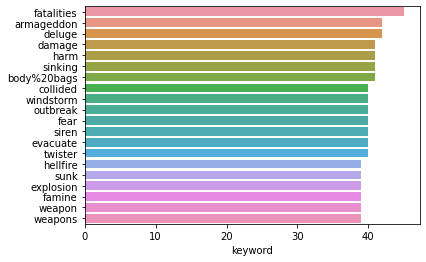

In [12]:
sns.barplot(y=train['keyword'].value_counts()[:20].index,
            x=train['keyword'].value_counts()[:20],
            orient='h')

In [13]:
train['text'][0:10]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update => California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7    I'm on top of the hill and I can see a fire in...
8    There's an emergency evacuation happening now ...
9    I'm afraid that the tornado is coming to our a...
Name: text, dtype: object

In [14]:
def text_cleaner(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

train['text'] = train['text'].apply(lambda x: text_cleaner(x))
test['text'] = test['text'].apply(lambda x: text_cleaner(x))

train['text'][0:20]

0     our deeds are the reason of this earthquake ma...
1                 forest fire near la ronge sask canada
2     all residents asked to shelter in place are be...
3      people receive wildfires evacuation orders in...
4     just got sent this photo from ruby alaska as s...
5     rockyfire update  california hwy  closed in bo...
6     flood disaster heavy rain causes flash floodin...
7     im on top of the hill and i can see a fire in ...
8     theres an emergency evacuation happening now i...
9      im afraid that the tornado is coming to our area
10          three people died from the heat wave so far
11    haha south tampa is getting flooded hah wait a...
12    raining flooding florida tampabay tampa  or  d...
13                flood in bago myanmar we arrived bago
14    damage to school bus on  in multi car crash br...
15                                         whats up man
16                                        i love fruits
17                                     summer is

In [15]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))

train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

In [16]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

train['text'] = train['text'].apply(lambda x: remove_stopwords(x))
test['text'] = test['text'].apply(lambda x: remove_stopwords(x))
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


In [17]:
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

train['text'] = train['text'].apply(lambda x: combine_text(x))
test['text'] = test['text'].apply(lambda x: combine_text(x))
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [18]:
def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    nopunc = text_cleaner(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [19]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train['text'])
test_vectors = count_vectorizer.transform(test['text'])

print(test_vectors[0].todense())

[[0 0 0 ... 0 0 0]]


In [20]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test["text"])

In [21]:
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.63149079, 0.60675773, 0.68575519, 0.64341085, 0.72505092])

In [22]:
clf_NB.fit(train_vectors, train["target"])

MultinomialNB()

In [23]:
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.57590597, 0.57092511, 0.61135371, 0.5962963 , 0.7393745 ])

In [24]:
clf_NB_TFIDF.fit(train_tfidf, train["target"])

MultinomialNB()

In [25]:
def submission(submission_file_path,model,test_vectors):
    sample_submission = pd.read_csv(submission_file_path)
    sample_submission["target"] = model.predict(test_vectors)
    test["target"] = sample_submission["target"]
    test.to_csv("submission.csv", index=False)
    

In [26]:
submission_file_path = "C:/Users/Bharadwaj/Documents/Capstone design/dataset/sample_submission.csv"
test_vectors = test_tfidf
submission(submission_file_path,clf_NB_TFIDF,test_vectors)

In [27]:
disaster_prediction = pd.read_csv('submission.csv',skip_blank_lines=False,error_bad_lines=True)
print(disaster_prediction)

         id keyword location  \
0         0     NaN      NaN   
1         2     NaN      NaN   
2         3     NaN      NaN   
3         9     NaN      NaN   
4        11     NaN      NaN   
...     ...     ...      ...   
3258  10861     NaN      NaN   
3259  10865     NaN      NaN   
3260  10868     NaN      NaN   
3261  10874     NaN      NaN   
3262  10875     NaN      NaN   

                                                   text  target  
0                           happened terrible car crash       1  
1     heard earthquake different cities stay safe ev...       0  
2     forest fire spot pond geese fleeing across str...       1  
3                 apocalypse lighting spokane wildfires       1  
4                   typhoon soudelor kills china taiwan       1  
...                                                 ...     ...  
3258  earthquake safety los angeles ûò safety fasten...       1  
3259  storm ri worse last hurricane hardest hit yard...       0  
3260                 

In [28]:
from selenium import webdriver
from selenium.webdriver.support import expected_conditions as ec
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time

def send_message():
    browser = webdriver.Chrome('D:\Games\chromedriver_win32\chromedriver.exe')
    browser.get('https://web.whatsapp.com/')
    wait = WebDriverWait(browser, 600)
    target = '"DISASTER"' #enter contact name here
    string = "Disaster Emminent! Check the news." #target msg
    x_arg = ' //span[contains(@title, ' + target +')]'
    target = wait.until(ec.presence_of_element_located((By.XPATH, x_arg)))
    target.click()
    inp_xpath = '//div[@class="_13NKt copyable-text selectable-text"][@contenteditable="true"][@data-tab="10"]'
    #input_box = browser.find_element_by_xpath('//*[contains(@class, "copyable-text selectable-text")]')
    input_box = browser.find_element_by_xpath(inp_xpath)

    time.sleep(10)
    input_box.send_keys(string + Keys.ENTER)
    time.sleep(2)
    browser.quit()

In [29]:
##****Give Location here****##
current_location = "36702 State Road 52, Dade City"
##****Give Location here****##

i = 0
lenofdp = disaster_prediction.shape[0]
dp_location = disaster_prediction["location"]
dp_target = disaster_prediction["target"]
while (i!=lenofdp-1):
    i+=1
    if (dp_location[i]==current_location) and (dp_target[i] == 1):
        send_message()